In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import re

In [5]:
filename_train = 'data/train.csv'
filename_test = 'data/test.csv'

df_train = pd.read_csv(filename_train)
df_test = pd.read_csv(filename_test)

In [6]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [34]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [12]:
import seaborn as sns

<AxesSubplot:xlabel='toxic', ylabel='count'>

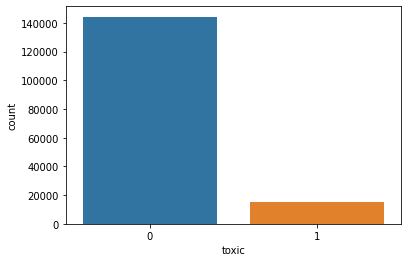

In [24]:
sns.countplot(x='toxic', data=df_train)

obscene          8449
insult           7877
severe_toxic     1595
identity_hate    1405
threat            478
dtype: int64


<AxesSubplot:>

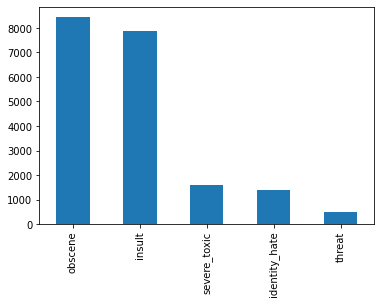

In [32]:
melted_class = df_train[['severe_toxic','obscene','threat','insult','identity_hate']].sum()
melted_class = melted_class.sort_values(ascending=False)
print(melted_class)
melted_class.plot(kind='bar')

In [35]:
train = df_train[['comment_text','toxic']]
train['toxic'].sum()

15294

In [40]:
train_1 = train[train['toxic'] == 1]
train_0 = train[train['toxic'] == 0].sample(n=train['toxic'].sum())

train_data = pd.concat([train_1, train_0])
train_data = train_data.sample(frac=1)
train_data.head()

,comment_text,toxic
138195,WOULD ANYBODY HERE LIKE TO GUESS WHAT I STUCK ...,1
481,"""\n\n Can there be a more concise listing? \n\...",0
133908,"If article does not say so, what is the purpos...",0
11078,Fuck you.\n\n'Fuck you in the ass.',1
50487,"Seventh, since Ratel is obviously wrong about ...",0


In [44]:
def remove_stopwords(sentence):
    """
    Removes a list of stopwords
    
    Args:
        sentence (string): sentence to remove the stopwords from
    
    Returns:
        sentence (string): lowercase sentence without the stopwords
    """
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    
    # Sentence converted to lowercase-only
    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence

def remove_symbols(sentence) :
    return re.sub(r'[^\w]', ' ', sentence)

In [45]:
train_data["text_no_stopwords"] = train_data["comment_text"].apply(lambda x : remove_stopwords(x))
train_data["text_final"] = train_data["text_no_stopwords"].apply(lambda x : remove_symbols(x))
train_data.head()

,comment_text,toxic,text_no_stopwords,text_final
138195,WOULD ANYBODY HERE LIKE TO GUESS WHAT I STUCK ...,1,anybody like guess stuck butt today?!?!,anybody like guess stuck butt today
481,"""\n\n Can there be a more concise listing? \n\...",0,""" can concise listing? listing """"other inventi...",can concise listing listing other inventi...
133908,"If article does not say so, what is the purpos...",0,"article not say so, purpose showing thiyya her...",article not say so purpose showing thiyya her...
11078,Fuck you.\n\n'Fuck you in the ass.',1,fuck you. 'fuck ass.',fuck you fuck ass
50487,"Seventh, since Ratel is obviously wrong about ...",0,"seventh, since ratel obviously wrong wikipedia...",seventh since ratel obviously wrong wikipedia...


In [85]:
def train_val_split(data, split) :
    train = []
    train_label = []
    validation = []
    val_label = []
    for ind,val in data.iterrows() :
        if len(train) < len(data)*split :
            train.append(val['text_final'])
            train_label.append(val['toxic'])
        else :
            validation.append(val['text_final'])
            val_label.append(val['toxic'])
    
    train = np.array(train)
    train_label = np.array(train_label)
    validation = np.array(validation)
    val_label = np.array(val_label)
    
    return train, train_label, validation, val_label

In [86]:
x_train, y_train, x_val, y_val = train_val_split(train_data, 0.9)

In [87]:
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
TRUNCATING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

In [88]:
def fit_tokenizer(train_sentences, oov_token) :
    
    tokenizer = Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(train_sentences)
    
    return tokenizer

In [89]:
tokenizer = fit_tokenizer(x_train, OOV_TOKEN)

word_index = tokenizer.word_index
NUM_WORDS = len(word_index)

training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences, maxlen=MAXLEN, padding=PADDING, truncating=TRUNCATING)

validation_sequences = tokenizer.texts_to_sequences(x_val)
validation_padded = pad_sequences(validation_sequences, maxlen=MAXLEN, padding=PADDING, truncating=TRUNCATING)

In [132]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=MAXLEN),
    tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 120, 16)           942720    
                                                                 
 dropout_8 (Dropout)         (None, 120, 16)           0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 120, 64)          12544     
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 120, 32)          10368     
 onal)                                                           
                                                                 
 conv1d_15 (Conv1D)          (None, 116, 64)           10304     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 58, 64)          

In [133]:
# Compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [134]:
num_epochs = 10

# Train the model
history = model.fit(training_padded, y_train, epochs=num_epochs, validation_data=(validation_padded, y_val))

Epoch 1/10
861/861 [==============================] - 19s 17ms/step - loss: 0.3576 - accuracy: 0.8300 - val_loss: 0.2325 - val_accuracy: 0.9078
Epoch 2/10
861/861 [==============================] - 14s 16ms/step - loss: 0.1552 - accuracy: 0.9425 - val_loss: 0.2315 - val_accuracy: 0.9026
Epoch 3/10
861/861 [==============================] - 14s 16ms/step - loss: 0.0975 - accuracy: 0.9670 - val_loss: 0.2441 - val_accuracy: 0.9114
Epoch 4/10
861/861 [==============================] - 14s 16ms/step - loss: 0.0673 - accuracy: 0.9771 - val_loss: 0.2539 - val_accuracy: 0.9035
Epoch 5/10
861/861 [==============================] - 14s 16ms/step - loss: 0.0476 - accuracy: 0.9846 - val_loss: 0.3403 - val_accuracy: 0.9035
Epoch 6/10
861/861 [==============================] - 13s 16ms/step - loss: 0.0351 - accuracy: 0.9887 - val_loss: 0.3326 - val_accuracy: 0.9003
Epoch 7/10
861/861 [==============================] - 13s 16ms/step - loss: 0.0300 - accuracy: 0.9898 - val_loss: 0.3939 - val_accuracy:

In [136]:
%%time
text = "Fuck off, you anti-semitic cunt."
text_after_stopwords = remove_stopwords(text)
text_clean = remove_symbols(text_after_stopwords)

text_sequence = tokenizer.texts_to_sequences([text_clean])
text_padded = pad_sequences(text_sequence, maxlen=MAXLEN, padding=PADDING, truncating=TRUNCATING)

if model.predict(text_padded)[0][0] > 0.5 :
    print("The text submitted was toxic")
else :
    print("No toxicity detected")

The text submitted was toxic
CPU times: user 93.7 ms, sys: 14.8 ms, total: 108 ms
Wall time: 63.5 ms


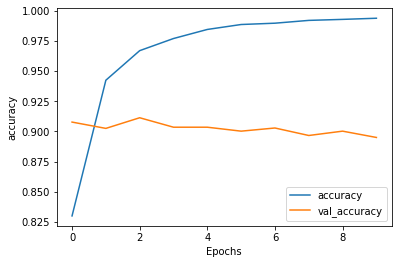

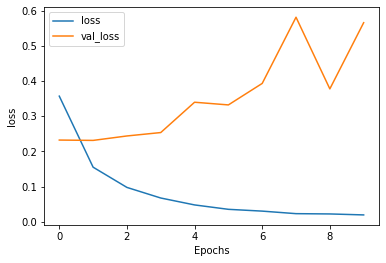

In [137]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [139]:
df_test_label = pd.read_csv("data/test_labels.csv")
df_test_label

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


In [144]:
test_data = df_test
test_data["no_stopwords"] = test_data["comment_text"].apply(lambda x: remove_stopwords(x))
test_data["text_clean"] = test_data["no_stopwords"].apply(lambda x: remove_symbols(x))

test_data = test_data.join(df_test_label.set_index("id"), on="id")
test_data = test_data[~(test_data['toxic'] == -1)]
test_data.head()

,id,comment_text,no_stopwords,text_clean,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very high...,thank understanding. think highly not revert w...,thank understanding think highly not revert w...,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,:dear god site horrible.,dear god site horrible,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...","""::: somebody will invariably try add religion...",somebody will invariably try add religion...,0,0,0,0,0,0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",""" says right type. """"type"""" institution needed...",says right type type institution needed...,0,0,0,0,0,0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",""" == adding new product list, make sure releva...",adding new product list make sure releva...,0,0,0,0,0,0


In [159]:
test_1 = test_data[test_data["toxic"] == 1]
test_0 = test_data[test_data["toxic"] == 0].sample(n = len(test_1))

test_data = pd.concat([test_1,test_0]).sample(frac = 1)

In [160]:
text_test = test_data["comment_text"].values
test_label = test_data["toxic"].values

text_sequence = tokenizer.texts_to_sequences(text_test)
text_padded = pad_sequences(text_sequence, maxlen=MAXLEN, padding=PADDING, truncating=TRUNCATING)

y_predicted = model.predict(text_padded)

In [161]:
test_predicted = [1 if x > 0.5 else 0 for x in y_predicted]

In [162]:
from sklearn.metrics import classification_report

print(classification_report(test_label, test_predicted))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84      6090
           1       0.82      0.91      0.86      6090

    accuracy                           0.85     12180
   macro avg       0.86      0.85      0.85     12180
weighted avg       0.86      0.85      0.85     12180



In [163]:
model.save('model/toxic_classification')

2023-01-03 08:17:49.912375: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/toxic_classification/assets


INFO:tensorflow:Assets written to: model/toxic_classification/assets


In [164]:
model.save('model/toxic_classification.h5')